In [1]:
import torch
from torch.utils.data import Dataset
from torch.utils.data import DataLoader, random_split
from torch import nn
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import nibabel as nib
import os

In [2]:
!pwd

/home/ljd2160


In [3]:
device = torch.device("cuda:1")
device

device(type='cuda', index=1)

# Dataloader

In [4]:
data_path = "~/research/OASIS1/LST/S0001"
annotations_file = "~/research/OASIS1/oasis_cross-sectional.csv"


In [5]:
class OASIS(Dataset):
    def __init__(self, annotations_file, data_path, transform=None):
        # clean up the csv file so that only the ID and CDR columns are left
        self.labels = pd.read_csv(annotations_file)
        self.labels = self.labels[['ID', 'CDR']]
        self.labels = self.labels.dropna(subset=['CDR'])
        self.labels = self.labels.reset_index(drop=True)
        self.labels['CDR'] = [1 if i> 0 else 0 for i in self.labels['CDR']]

        self.data_path = data_path
        self.transform = transform


    def __len__(self):
        return len(self.labels)
        
    def __getitem__(self, idx):
        img_filename = self.labels.iloc[idx, 0].replace("MR1", "S0001_T1_O_nu_acpc.nii")
        img_path = os.path.join(data_path, img_filename)
        nifti = nib.load(img_path)
        img = np.float32(nifti.get_fdata()).reshape(1, 256, 256, 160)
        label = self.labels.iloc[idx, 1]
        return img, label

        

## test dataloader

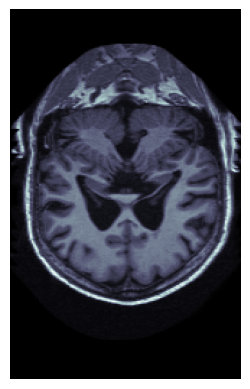

0
(1, 256, 256, 160)


In [6]:
oasis = OASIS(annotations_file, data_path)
img, label = oasis[0]
plt.imshow(img[0][96], cmap = 'bone')
plt.axis('off')
plt.show()
print(label)
print(img.shape)

## test and train split

In [7]:
train_size = int(0.8 * len(oasis))
test_size = len(oasis) - train_size
train_dataset, test_dataset = random_split(oasis, [train_size, test_size])
train_loader = DataLoader(train_dataset, batch_size=1, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=1, shuffle=True)

In [8]:
img, label = next(iter(train_loader))

print(img.shape)

torch.Size([1, 1, 256, 256, 160])


# NeuralNetwork

In [9]:
class vgg11(nn.Module):
    def __init__(self, num_channels, n_classes):
        super(vgg11, self).__init__()
        self.features = nn.Sequential(
            nn.Conv3d(num_channels, 64, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool3d(kernel_size=2, stride=2),
            nn.Conv3d(64, 128, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool3d(kernel_size=2, stride=2),
            nn.Conv3d(128, 256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv3d(256, 256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool3d(kernel_size=2, stride=2),
            nn.Conv3d(256, 512, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv3d(512, 512, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool3d(kernel_size=2, stride=2),
            nn.Conv3d(512, 512, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv3d(512, 512, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool3d(kernel_size=2, stride=2)
        )
        self.avgpool = nn.AdaptiveAvgPool3d((1, 1, 1))
        self.classifier = nn.Sequential(
            nn.Linear(512, 4096),
            nn.ReLU(inplace=True),
            nn.Linear(4096, 4096),
            nn.ReLU(inplace=True),
            nn.Linear(4096, n_classes),
            nn.Sigmoid()
        )   

    def forward(self, x):
        x = self.features(x)
        x = self.avgpool(x)
        x = torch.flatten(x, 1)
        x = self.classifier(x)
        return x.squeeze(1)
    


## test output

In [10]:
my_vgg = vgg11(1, 1)


# Training

In [11]:
optimizer = torch.optim.Adam(my_vgg.parameters(), lr=0.001)
loss_function = nn.BCELoss()

In [12]:
def train_net(net, epochs, train_dataloader, optimizer, loss_function):
    net.train()
    for epoch in range(epochs):
        for i, (img, label) in enumerate(train_dataloader):
            img = img.to(device)
            label = label.to(device)
            optimizer.zero_grad()
            y_pred = net(img)
            loss = loss_function(y_pred, label.float())
            loss.backward()
            optimizer.step()
            if i % 10 == 0:
                print(f'Epoch {epoch}, Loss {loss.item()}')
    

In [13]:
def test_net(net, test_dataloader):
    net.eval()
    with torch.no_grad():
        correct = 0
        total = 0
        for i, (img, label) in enumerate(test_dataloader):
            img = img.to(device)
            label = label.to(device)
            y_pred = net(img)
            y_pred = torch.round(y_pred)
            total += label.size(0)
            correct += (y_pred == label).sum().item()
        print(f'Accuracy: {correct/total}')

In [14]:
my_vgg.to(device)
train_net(my_vgg, 5, train_loader, optimizer, loss_function)

Epoch 0, Loss 0.6790560483932495
Epoch 0, Loss 100.0
Epoch 0, Loss 100.0
Epoch 0, Loss 0.0
Epoch 0, Loss 100.0
Epoch 0, Loss 100.0
Epoch 0, Loss 0.0
Epoch 0, Loss 0.0
Epoch 0, Loss 100.0
Epoch 0, Loss 0.0
Epoch 0, Loss 0.0
Epoch 0, Loss 100.0
Epoch 0, Loss 100.0
Epoch 0, Loss 100.0
Epoch 0, Loss 0.0
Epoch 0, Loss 0.0
Epoch 0, Loss 100.0
Epoch 0, Loss 0.0
Epoch 0, Loss 0.0
Epoch 1, Loss 0.0
Epoch 1, Loss 0.0
Epoch 1, Loss 100.0
Epoch 1, Loss 0.0
Epoch 1, Loss 0.0
Epoch 1, Loss 100.0
Epoch 1, Loss 100.0
Epoch 1, Loss 0.0
Epoch 1, Loss 100.0
Epoch 1, Loss 0.0
Epoch 1, Loss 100.0
Epoch 1, Loss 100.0
Epoch 1, Loss 0.0
Epoch 1, Loss 0.0
Epoch 1, Loss 0.0
Epoch 1, Loss 100.0
Epoch 1, Loss 0.0
Epoch 1, Loss 0.0
Epoch 1, Loss 0.0
Epoch 2, Loss 0.0
Epoch 2, Loss 0.0
Epoch 2, Loss 100.0
Epoch 2, Loss 100.0
Epoch 2, Loss 0.0
Epoch 2, Loss 100.0
Epoch 2, Loss 0.0
Epoch 2, Loss 100.0
Epoch 2, Loss 100.0
Epoch 2, Loss 100.0
Epoch 2, Loss 100.0
Epoch 2, Loss 100.0
Epoch 2, Loss 100.0
Epoch 2, Loss 100

In [15]:
test_net(my_vgg, test_loader)

Accuracy: 0.425531914893617
